In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping
from keras.layers.merge import concatenate

from math import ceil

import seaborn as sns
sns.set()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [119]:
input_dataset_path = 'drive/MyDrive/Collab-Datasets/nasd_input.csv'
query_dataset_path = 'drive/MyDrive/Collab-Datasets/nasd_query.csv'
DATASET_SIZE = 1
LOOKBACK = 15

In [120]:
timeseries_df = pd.read_csv(input_dataset_path, sep='\t', index_col=0, header=None).astype(np.float32).sample(DATASET_SIZE)
TIME_SERIES_ID = timeseries_df.index.tolist()

In [121]:
def normalize(X, _max, _min):
  return (X - _min)/(_max-_min) 

def reverse_normalize(X, _max, _min):
  return X*(_max-_min) + _min 

def preprocess_timeseries(_timeseries, window=10, normalized=False, _max = None, _min = None):
  if not normalized:
    if _max is None:
      _max = _timeseries.min()
    if _min is None:
      _min = _timeseries.max()

    timeseries = normalize(_timeseries, _max, _min)
  else:
    timeseries = _timeseries
  
  X = None
  for i in range(window, len(timeseries)):
    X_i = np.asarray(timeseries[i-window:i]).reshape((1, len(timeseries[i-window:i]), 1))
    X = np.concatenate((X, X_i)) if X is not None else X_i
    
  return X, _max, _min

In [123]:
window_length = 15
X_all, _max, _min = preprocess_timeseries(timeseries_df.to_numpy()[0], window_length)
print(X_all.shape)
X_train, X_test = train_test_split(X_all, test_size=0.33)

(715, 15, 1)


In [177]:
class TimeSeriesComplexityReducer():
  n_conv_filt_default = 10
  def __init__(self, window_size, conv_layers_setting=[], latent_dim=3, batch_size=64, pool_size=2, verbose=False):
    self.batch_size = batch_size 
    self.verbose=verbose
    
    # init input layer
    input_w = layers.Input(shape=(window_size,1))
    input_dim = window_size
    x = input_w

    # add the convolution layers
    for conv_settings in conv_layers_setting:
      # set up convolution filters and kernel dimensions 
      filters = self.n_conv_filt_default
      if 'filters' in conv_settings:
        filters = conv_settings['filters']
      kernel_size = conv_settings['kernel_size']

      # add the layer into the encoder
      x = layers.Conv1D(filters, kernel_size, padding="same", activation="relu")(x)
      
      # downsample if you can
      if ceil(input_dim/pool_size) > latent_dim:
        input_dim = ceil(input_dim/pool_size)
        x = layers.MaxPooling1D(pool_size, padding="same")(x)

    # final compression
    x = layers.Flatten()(x)
    x = layers.Dense(latent_dim, activation='relu')(x)
    encoded = layers.Reshape((latent_dim, 1))(x)
    
    self.encoder = models.Model(input_w, encoded, name='encoder')
    if self.verbose:
      self.encoder.summary()    


    # decoder model
    output_dim = latent_dim 

    x = layers.Conv1DTranspose(1, latent_dim, activation='relu', padding="same")(encoded)
    
    if output_dim*pool_size <= window_size:
        output_dim = output_dim*pool_size
        x = layers.UpSampling1D(pool_size)(x)

    for i, conv_settings in enumerate(conv_layers_setting[::-1]):
      padding="same"
      filters = self.n_conv_filt_default
      if 'filters' in conv_settings:
        filters = conv_settings['filters']
      kernel_size = conv_settings['kernel_size']

      x = layers.Conv1DTranspose(filters, kernel_size, activation="relu", padding=padding)(x)
      
      if output_dim*pool_size <= window_size:
        output_dim = output_dim*pool_size
        x = layers.UpSampling1D(pool_size)(x)

    # decoded = layers.Conv1DTranspose(1, window_size-output_dim+1, activation="sigmoid")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(window_size, activation='sigmoid')(x)
    decoded = layers.Reshape((window_size, 1))(x)

    self.autoencoder = models.Model(input_w, decoded, name="autoencoder")
    self.autoencoder.summary()
    self.autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


  def fit(self, X, y, epochs=50):
    self.history = self.autoencoder.fit(X, y,
                epochs=epochs,
                batch_size=self.batch_size,
                shuffle=True,
                validation_split=0.3, 
                verbose=self.verbose)
    return self.history
  def predict(self, X):
    return self.autoencoder.predict(X)

In [194]:
autoencoder = TimeSeriesComplexityReducer(window_length, [{'filters':20, 'kernel_size':5}, {'filters':10, 'kernel_size':5}, {'filters':5, 'kernel_size':3}], latent_dim=10, verbose=True, pool_size=2)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_83 (InputLayer)       [(None, 15, 1)]           0         
                                                                 
 conv1d_391 (Conv1D)         (None, 15, 20)            120       
                                                                 
 conv1d_392 (Conv1D)         (None, 15, 10)            1010      
                                                                 
 conv1d_393 (Conv1D)         (None, 15, 5)             155       
                                                                 
 flatten_20 (Flatten)        (None, 75)                0         
                                                                 
 dense_28 (Dense)            (None, 10)                760       
                                                                 
 reshape_20 (Reshape)        (None, 10, 1)             0   

In [195]:
autoencoder.fit(X_train, X_train, epochs=100)

Epoch 1/100
6/6 [==============================] - 1s 71ms/step - loss: 0.6910 - val_loss: 0.6867
Epoch 2/100
6/6 [==============================] - 0s 12ms/step - loss: 0.6821 - val_loss: 0.6727
Epoch 3/100
6/6 [==============================] - 0s 15ms/step - loss: 0.6632 - val_loss: 0.6455
Epoch 4/100
6/6 [==============================] - 0s 14ms/step - loss: 0.6292 - val_loss: 0.6037
Epoch 5/100
6/6 [==============================] - 0s 15ms/step - loss: 0.5862 - val_loss: 0.5837
Epoch 6/100
6/6 [==============================] - 0s 12ms/step - loss: 0.5850 - val_loss: 0.5863
Epoch 7/100
6/6 [==============================] - 0s 12ms/step - loss: 0.5763 - val_loss: 0.5771
Epoch 8/100
6/6 [==============================] - 0s 14ms/step - loss: 0.5739 - val_loss: 0.5782
Epoch 9/100
6/6 [==============================] - 0s 11ms/step - loss: 0.5732 - val_loss: 0.5748
Epoch 10/100
6/6 [==============================] - 0s 14ms/step - loss: 0.5715 - val_loss: 0.5740
Epoch 11/100
6/6 [=

In [196]:
def plot_examples(stock_input, stock_decoded):
    n = 10  
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(list(np.arange(0, test_samples, 200))):
        # display original
        ax = plt.subplot(2, n, i + 1)
        if i == 0:
            ax.set_ylabel("Input", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_input[idx])
        ax.get_xaxis().set_visible(False)
        

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        if i == 0:
            ax.set_ylabel("Output", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_decoded[idx])
        ax.get_xaxis().set_visible(False)

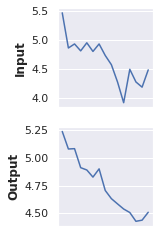

In [197]:
test_samples = 50

plot_examples(reverse_normalize(X_test, _max, _min), reverse_normalize(autoencoder.predict(X_test), _max, _min))

In [ ]:
autoencoder.predict(X_test).shape

(238, 10, 1)

In [ ]:
X_test.shape

(238, 10, 1)